In [180]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy.random import rand
from sklearn.metrics import accuracy_score

df = pd.read_csv('ionosphere.csv')
df = df.values

In [181]:
#extracted features and labels from the data

features  = np.asarray(df[:, 0:-1])
labels = np.asarray(df[:, -1])

In [182]:
#data split for training and testing ..
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.3, random_state=0)

In [183]:
#function to create an initial position matrics of the swarms
#basically it will initialize the position for each particle randomly

def initial_positions(lower_bound, upper_bound, no_of_particles, dimension):

  #positions array will be initialized with al zeros, size = no. of particles * total number of features(in this case)
  positions = np.zeros([no_of_particles,dimension], dtype='float')
  
  # now iterate through this whole matrices , and assign a random value to each variable of each particle

  for i in range(no_of_particles):
    for d in range(dimension):
      #lower bound is a vector of all zeros and upper bound is a matrics of all ones
      # here we a using rand() to generate a random number 0-1 
      positions[i,d] = lower_bound[0,d]+(upper_bound[0,d]-lower_bound[0,d])*rand()
  
  return positions

In [184]:
#this function will assign velocity of each variable in the particle with random variables

def initial_velocities(lower_bound, upper_bound,no_of_particles, dimensions):

  #initialized three matrices 

  #first one is to store the velocities of each variable in the particles
  velocities = np.zeros([no_of_particles, dimensions], dtype='float')

  #second is to store the best velocity of the particle among all the variables
  velocity_max = np.zeros([1,dimensions], dtype='float')

  #third is to store the minimun velocity of the particle among all the variables
  velocity_min = np.zeros([1,dimensions], dtype='float')

  #initialising the max and min veocity vectors with the random values
  for d in range(dimensions):
    velocity_max[0,d] = (upper_bound[0,d] - lower_bound[0,d])/2
    velocity_min[0,d] = -velocity_max[0,d]

  #initialising the velocities with the random values using min and max velocities
  # min and max velocities are acting like some sort of limit on the value of the velocities 
  for i in range(no_of_particles):
    for d in range(dimensions):
      velocities[i,d] = velocity_min[0,d] + (velocity_max[0,d] - velocity_min[0,d])*rand()

  return velocities, velocity_max, velocity_min

In [185]:
#This function will just convert the given particle into its binary form
#basically this function will tell us which feature we have to take or not

def to_binary(positions , threshold, no_of_particles, dimensions):
  position_bin = np.zeros([no_of_particles, dimensions], dtype='int')

  #it simplye works like -> if the value at the position is greater than the 
  # given threshold then it will simply make it one. hence we are choosing that feature
  # else if less than threshold just make it zero, means we are not choosing that feature

  for i in range(no_of_particles):
    for d in range(dimensions):
      if(positions[i,d]>threshold):
        position_bin[i,d]=1

      else:
        position_bin[i,d]=0

  return position_bin

In [186]:
# this function is just to check this we are within the permisible range of the values,
# if not, than just make them within range

def boundary(value, lb,ub):
  if value<lb:
    value = lb

  if value > ub:
    value = ub

  return value

In [187]:
# this function will calculate the error associated with all the particles, with the number of featues chosen in them

def error_rate(particle):
 
  num_train = np.size(xtrain,0)
  num_test = np.size(xtest,0)

  new_xtrain = xtrain[:,particle==1]
  new_ytrain = ytrain.reshape(num_train)
  new_xtest = xtest[:,particle==1]
  new_ytest = ytest.reshape(num_test)

  decision_model = DecisionTreeClassifier(criterion='gini')

  decision_model.fit(new_xtrain, new_ytrain)

  predictions = decision_model.predict(new_xtest)

  score = accuracy_score(ytest, predictions)
  # score = np.sum(new_ytest == predictions)/num_test

  error = 1 - score

  return error 

In [188]:
# this function is used to calculate the cost associated with each of the particles /

def fitness_function(particle):
  alpha = 0.9
  beta = 1-alpha

  max_features = len(particle)

  selected_features = np.sum(particle == 1)

  if selected_features == 0:
    cost = 1

  else:
    error = error_rate(particle)

    # just a simple formula for the calculation
    cost = alpha*error + beta*(selected_features/max_features)

  return cost



In [189]:
# main function that will run the PSO and working of the PSO

def run_PSO():

  # here first we are going to initialize some variables that will help us in 
  # finding the initial positions and the initial velocities 
  upper_bound =1
  lower_bound=0

  #these are some of the varibale we will be using, we we will update te velocities and the positions
  threshold = 0.5
  w = 0.9
  c1 = 2
  c2 = 2

  # we are choosing number of particles as 10 and we will run total 100 iterations here
  no_of_particles= 10
  maximum_iterations = 100

  # so first we have created two arrays upper and lower bounds that will be used in 
  # calculations of the intial positions and the velocities

  dimensions = np.size(xtrain,1)
  if np.size(lower_bound)==1:
    upper_bound = upper_bound*np.ones([1,dimensions], dtype='float')
    lower_bound = lower_bound*np.ones([1,dimensions], dtype = 'float')

  
  #here we are calling our initial_positions() functions to get the initial positionS  of the particles.. 
  positions = initial_positions(lower_bound, upper_bound, no_of_particles, dimensions)

  #similarly for initial velocities -> obviously both will ghet some random variables
  velocities, velocities_max, velocities_min = initial_velocities(lower_bound, upper_bound, no_of_particles, dimensions)

  
  # here we have created some matrices and vectors of zeros ,and some variables to store the postions , best positions, fitenss, best_fitness etc
  # names are self explanatory here

  fitness_of_particles = np.zeros([no_of_particles,1], dtype = 'float')
  best_fitness_of_particles = float('inf')*np.ones([no_of_particles,1], dtype='float')
  global_best_fitness = float('inf')
  best_particle_position = np.zeros([no_of_particles,dimensions], dtype = 'float')
  global_best_positions = np.zeros([1,dimensions], dtype = 'float')

  # this matrices will store our global_best_fitness value at each iteration.. 

  curve = np.zeros([1,maximum_iterations], dtype = 'float')
  t = 0  #a variable to keep the counter of number of iterations.


  # loop to keep the iterations on for the selection of the best result
  while t<maximum_iterations:
      
      #call to to_binary() functiion to convert matrices into values of ones and zeros only 
      position_bin = to_binary(positions, threshold, no_of_particles, dimensions)

      # this loop will iterate through our population and for each particle it will find the fitness value and do the need full
      for i in range (no_of_particles):
          fitness_of_particles[i,0]=fitness_function(position_bin[i,:])

          # if(fitness of current particle is better than its previous best value -> then do this updation)
          if fitness_of_particles[i,0] < best_fitness_of_particles[i,0]:
            #best_position will be updated to the current position
            best_particle_position[i,:] = positions[i,:]
            # and best fitness value will be updated to the current fitness value
            best_fitness_of_particles[i,0] = fitness_of_particles[i,0]

          #similarly if it is better than the global best value then update global best fitness value as well as the global best position  
          if best_fitness_of_particles[i,0] < global_best_fitness:
            global_best_positions[0,:] = best_particle_position[i,:]
            global_best_fitness = best_fitness_of_particles[i,0]

      #here will will just store the global fitness score at each of the iterations, just to use that to plot later.
      curve[0,t] = global_best_fitness.copy()
      t +=1

      #update the position and the velocity values of the variable of each particle and and move to the next iteration 
      for i in range(no_of_particles):
        for d in range(dimensions):
          r1 = rand()
          r2 = rand()
          
          # update velocity using this given formula here where c1 and c2 are accelaration factors, w is the inertia weight and r1 and r2 are random numbers 
          velocities[i,d] = w * velocities[i,d] + c1*r1*(best_particle_position[i,d]-positions[i,d]) + c2*r2*(global_best_positions[0,d]-positions[i,d])

          # to keep the values of velocities and positions within a permisible range
          velocities[i,d] = boundary(velocities[i,d],velocities_min[0,d], velocities_max[0,d])

          #update the position also 
          positions[i,d] = positions[i,d] + velocities[i,d]

          positions[i,d] = boundary(positions[i,d], lower_bound[0,d], upper_bound[0,d])


  #the answers after the iterations complete and we are returning these values to aur calling function. 
  global_best_binary = to_binary(global_best_positions, threshold, 1, dimensions)
  global_best_binary = global_best_binary.reshape(dimensions)
  pos = np.asarray(range(0,dimensions))
  selected_indexes = pos[global_best_binary==1]
  number_of_features_selected = len(selected_indexes)

  pso_data = {'sf':selected_indexes, 'c':curve, 'nf':number_of_features_selected}
  
  return pso_data


Accuracy:  93.39622641509435
feature size:  14
selected features:  [ 1  4  7  8  9 13 14 15 16 17 21 23 27 31]


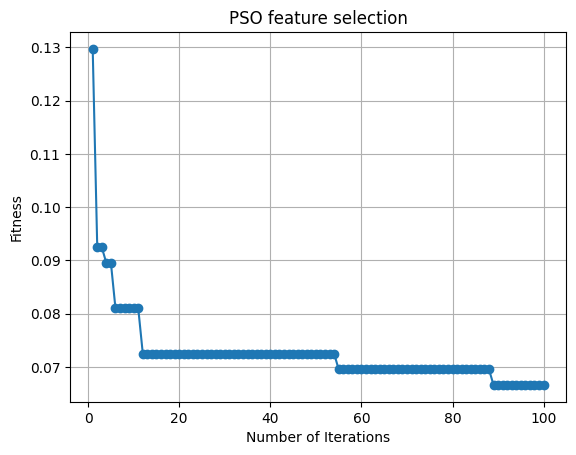

In [190]:
output_of_pso = run_PSO()

# print(output_of_pso)

#training the mode with the selected features and finding the new accuracy score

selected_features = output_of_pso['sf']

x_train = xtrain[:,selected_features]
x_test = xtest[:,selected_features]

y_train = ytrain
y_test = ytest

new_model = DecisionTreeClassifier(criterion='gini')

new_model.fit(x_train, y_train)

new_predictions = new_model.predict(x_test)

new_score = accuracy_score(ytest, new_predictions)

new_score = new_score*100

print("Accuracy: ",new_score)

print("feature size: ", output_of_pso['nf'])

print("selected features: ", output_of_pso['sf'])

curve = output_of_pso['c']
curve = curve.reshape(np.size(curve,1))
x = np.arange(0,100,1.0) + 1.0


#graph ploting for the whole process if PSO, to show the convergence.
fig , ax = plt.subplots()
ax.plot(x,curve,'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO feature selection')
ax.grid()
plt.show()

In [191]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy.random import rand
from sklearn.metrics import accuracy_score

data = pd.read_csv('ionosphere.csv')
data 

features1 = data.drop(['label'], axis=1)
targets1 = data['label']

x_train1, x_test1, y_train1, y_test1 = train_test_split(features1, targets1, random_state=0)

modell = DecisionTreeClassifier(criterion='gini')

modell.fit(x_train1, y_train1)

new_predictions11 = modell.predict(x_test1)

score11 = accuracy_score(y_test1, new_predictions11)

print(score11)

0.8863636363636364
